In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
DEVICE = 'laptop'
SUBTRACT_IDLE = True

match DEVICE:
    case 'cn': IDLE = 3.38
    case 'fpga': IDLE = 52.90
    case 'laptop': IDLE = 2.78

path_math = f'scripts/{DEVICE}/math.csv'
path_matmul = f'scripts/{DEVICE}/matmul.csv'
path_sleepy = f'scripts/{DEVICE}/sleepy.csv'

In [10]:
def read_csv(path):
    df = pd.read_csv(path)
    df = df[df['dynamic'] == False]
    df.drop(['dynamic'], axis=1, inplace=True)

    df['W'] = df['energy'] / df['runtime']

    if SUBTRACT_IDLE:
        df['energy'] -= df['runtime'] * IDLE
        assert((df['energy'] > 0).all())

    real_max = df['runtime'] * df['threads']
    user_pct = df['usertime'] / real_max
    user_pct = user_pct.clip(upper=1.0)
    df['usertime'] /= df['threads']
    df['user-pct'] = user_pct
    df['energy-user'] = df['energy'] * user_pct

    df0 = df[df['busy'] == 0]
    return df, df0

In [11]:
df_math,   df_math0   = read_csv(path_math)
df_matmul, df_matmul0 = read_csv(path_matmul)
df_sleepy, df_sleepy0 = read_csv(path_sleepy)
df_matmul, df_matmul0 = (df_sleepy, df_sleepy0)
df_matmul

,busy,threads,energy,runtime,usertime,W,user-pct,energy-user
0,0,1,3.114408,1.093681,0.365692,5.627639,0.334368,1.041358
1,0,2,1.680993,0.537361,0.174654,5.908238,0.325022,0.546359
2,0,3,1.455870,0.343479,0.100528,7.018598,0.292677,0.426100
3,0,4,1.313911,0.250411,0.068886,8.027011,0.275090,0.361444
4,0,5,1.300668,0.225564,0.054397,8.546303,0.241160,0.313669
...,...,...,...,...,...,...,...,...
139,16,12,1.484879,0.121644,0.028234,14.986788,0.232101,0.344642
140,16,13,1.483990,0.121643,0.026334,14.979511,0.216487,0.321265
141,16,14,1.357277,0.111195,0.024407,14.986278,0.219497,0.297918
142,16,15,1.240408,0.101707,0.022887,14.975873,0.225025,0.279123


In [12]:
df_math_speedup   = df_math.copy()
df_matmul_speedup = df_matmul.copy()

for col in df_math_speedup.columns[2:]:
    df_math_speedup[col]   = df_math_speedup[col].iloc[0]   / df_math_speedup[col]
    df_matmul_speedup[col] = df_matmul_speedup[col].iloc[0] / df_matmul_speedup[col]

df_math_speedup0   = df_math_speedup[df_math_speedup['busy'] == 0]
df_matmul_speedup0 = df_matmul_speedup[df_matmul_speedup['busy'] == 0]

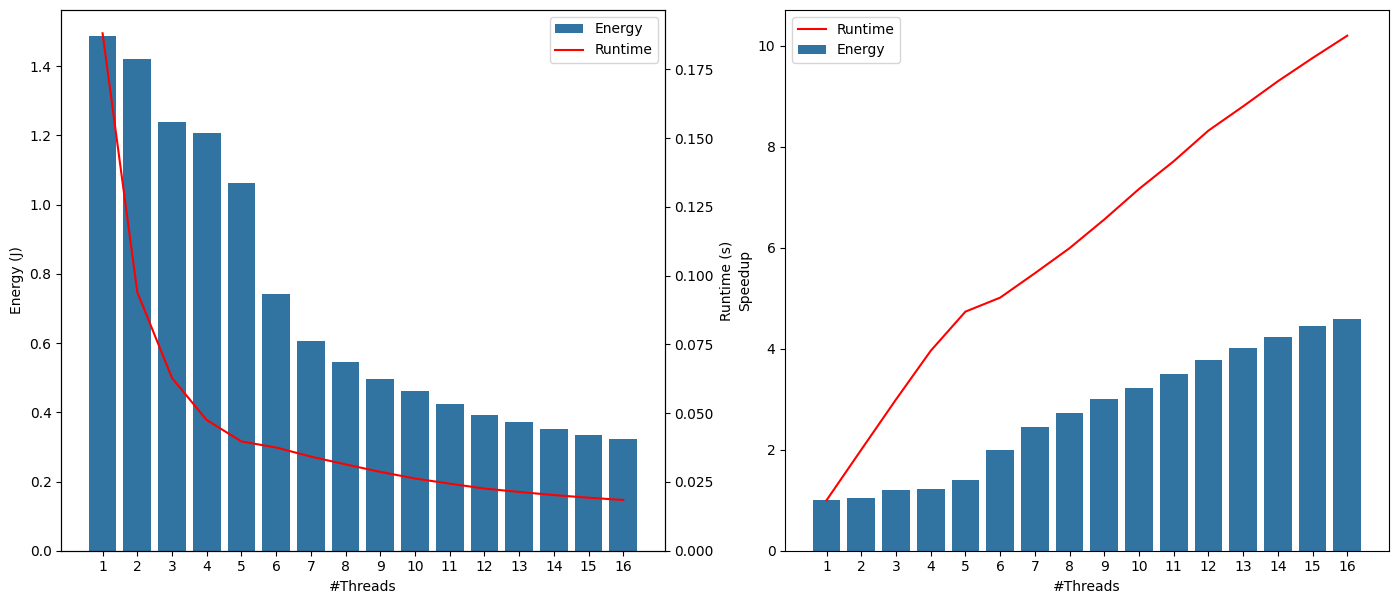

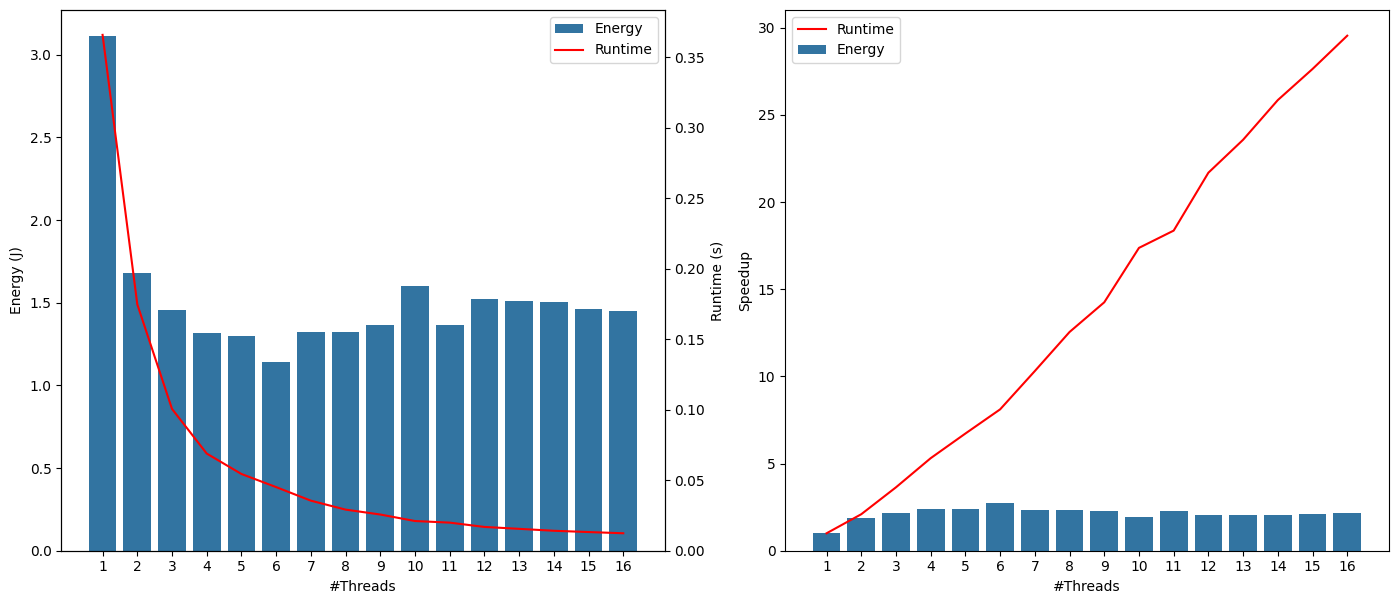

In [13]:
def plot(df0, df_speedup0):
    fig, (ax_energy1, ax_speedup) = plt.subplots(1, 2, figsize=(14,6))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    
    # Energy
    sns.barplot(df0, x='threads', y='energy', label='Energy', legend=False, ax=ax_energy1)
    ax_energy2 = ax_energy1.twinx()
    sns.lineplot(df0, x=df0.index, y='usertime', label='Runtime', color='r', ax=ax_energy2)

    ax_energy1.set_xlabel('#Threads')
    ax_energy1.set_ylabel('Energy (J)')
    ax_energy2.set_ylabel('Runtime (s)')
    ax_energy2.set_ylim((0, None))

    lines1, labels1 = ax_energy1.get_legend_handles_labels()
    lines2, labels2 = ax_energy2.get_legend_handles_labels()
    ax_energy2.legend(lines1 + lines2, labels1 + labels2)

    # Speedup
    sns.barplot(df_speedup0, x='threads', y='energy', label='Energy', ax=ax_speedup)
    sns.lineplot(df_speedup0, x=df_speedup0.index, y='usertime', label='Runtime', color='r', ax=ax_speedup)

    ax_speedup.set_xlabel('#Threads')
    ax_speedup.set_ylabel('Speedup')
    ax_speedup.set_ylim((0, None))

    plt.show()

plot(df_math0, df_math_speedup0)
plot(df_matmul0, df_matmul_speedup0)

# With busy threads

In [14]:
print('math:')
for (busy, df_busy) in df_math.groupby('busy'):
    best = df_busy[df_busy['energy'] == df_busy['energy'].min()].iloc[0]
    threads = int(best['threads'])
    energy = best['energy']
    print(f'{busy:2d} busy - Best: {threads:2d} threads @ {energy:.2f}J ({busy + threads} total workers)')

print()

print('matmul:')
for (busy, df_busy) in df_matmul.groupby('busy'):
    best = df_busy[df_busy['energy'] == df_busy['energy'].min()].iloc[0]
    threads = int(best['threads'])
    energy = best['energy']
    print(f'{busy:2d} busy - Best: {threads:2d} threads @ {energy:.2f}J ({busy + threads} total workers)')

math:
 0 busy - Best: 16 threads @ 0.32J (16 total workers)
 2 busy - Best: 16 threads @ 0.37J (18 total workers)
 4 busy - Best: 12 threads @ 0.42J (16 total workers)
 6 busy - Best: 10 threads @ 0.50J (16 total workers)
 8 busy - Best:  9 threads @ 0.62J (17 total workers)
10 busy - Best:  8 threads @ 0.82J (18 total workers)
12 busy - Best: 15 threads @ 0.97J (27 total workers)
14 busy - Best: 16 threads @ 1.07J (30 total workers)
16 busy - Best: 15 threads @ 0.88J (31 total workers)

matmul:
 0 busy - Best:  6 threads @ 1.14J (6 total workers)
 2 busy - Best: 16 threads @ 1.05J (18 total workers)
 4 busy - Best: 16 threads @ 1.06J (20 total workers)
 6 busy - Best: 16 threads @ 1.07J (22 total workers)
 8 busy - Best: 16 threads @ 0.85J (24 total workers)
10 busy - Best: 16 threads @ 0.88J (26 total workers)
12 busy - Best: 16 threads @ 1.08J (28 total workers)
14 busy - Best: 16 threads @ 1.38J (30 total workers)
16 busy - Best: 16 threads @ 1.18J (32 total workers)


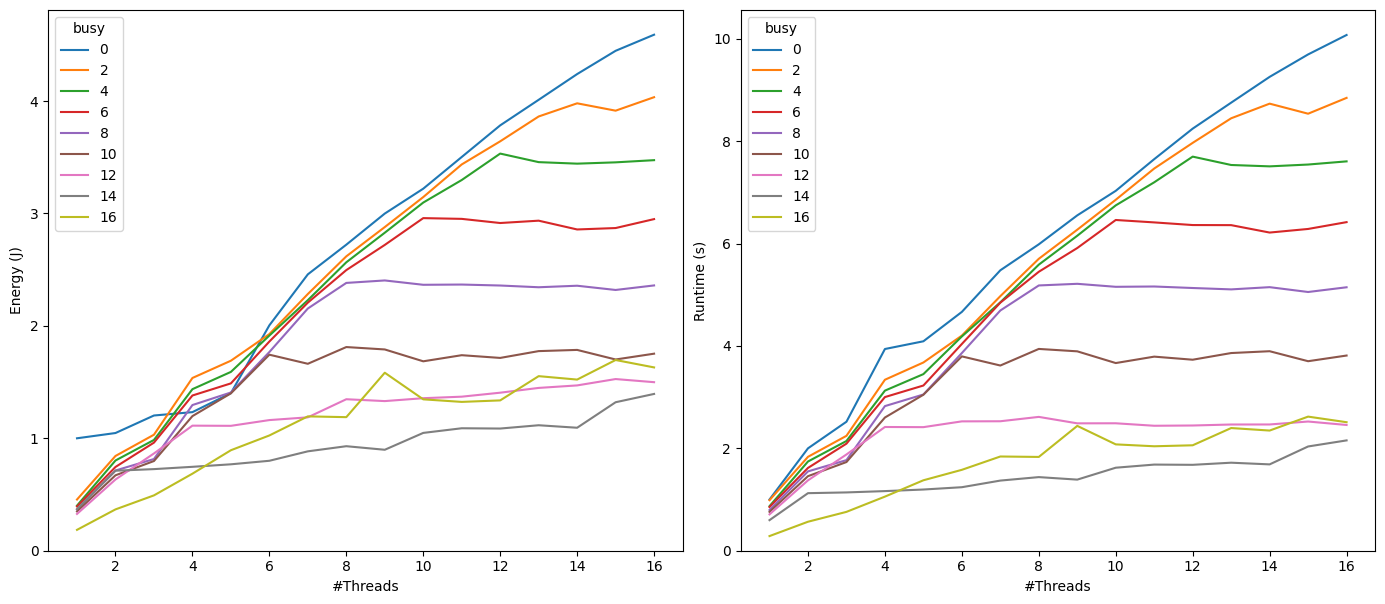

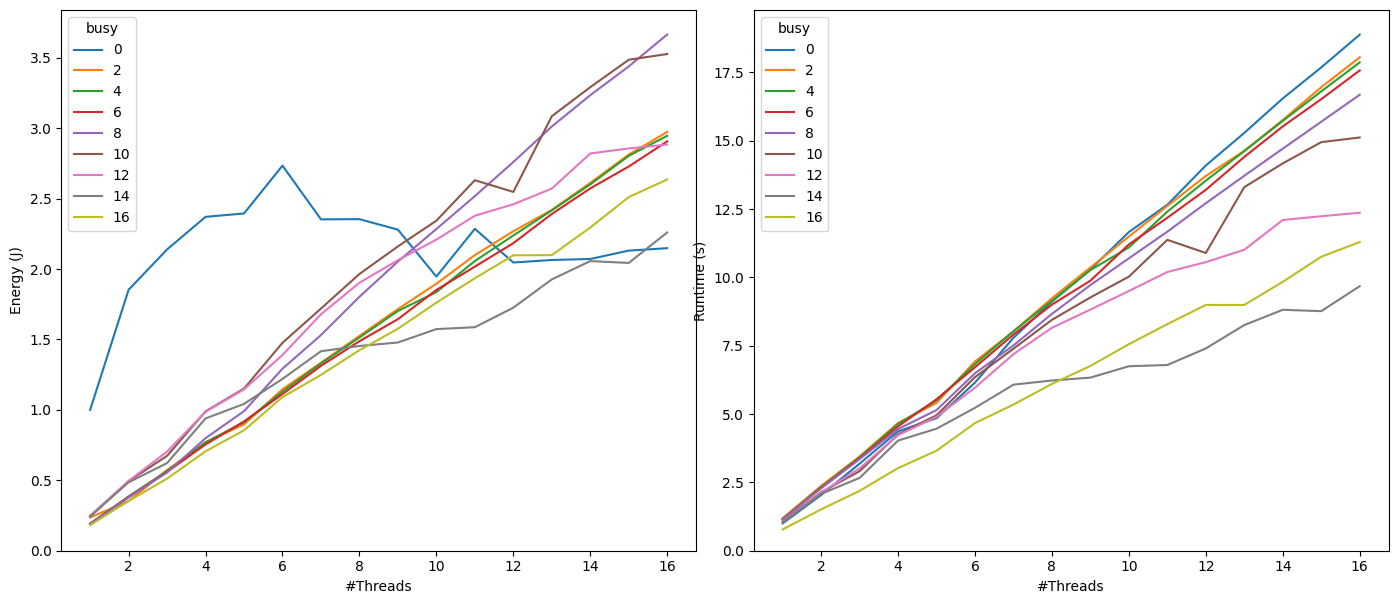

In [15]:
def plot(df):
    fig, (ax_energy, ax_runtime) = plt.subplots(1, 2, figsize=(14,6))
    fig.tight_layout()

    # Energy
    sns.lineplot(df, x='threads', y='energy', hue=df['busy'].astype('category'), ax=ax_energy)
    ax_energy.set_xlabel('#Threads')
    ax_energy.set_ylabel('Energy (J)')
    ax_energy.set_ylim((0, None))

    # Runtime
    sns.lineplot(df, x='threads', y='runtime', hue=df['busy'].astype('category'), ax=ax_runtime)
    ax_runtime.set_xlabel('#Threads')
    ax_runtime.set_ylabel('Runtime (s)')
    ax_runtime.set_ylim((0, None))

    plt.show()

plot(df_math_speedup)
plot(df_matmul_speedup)

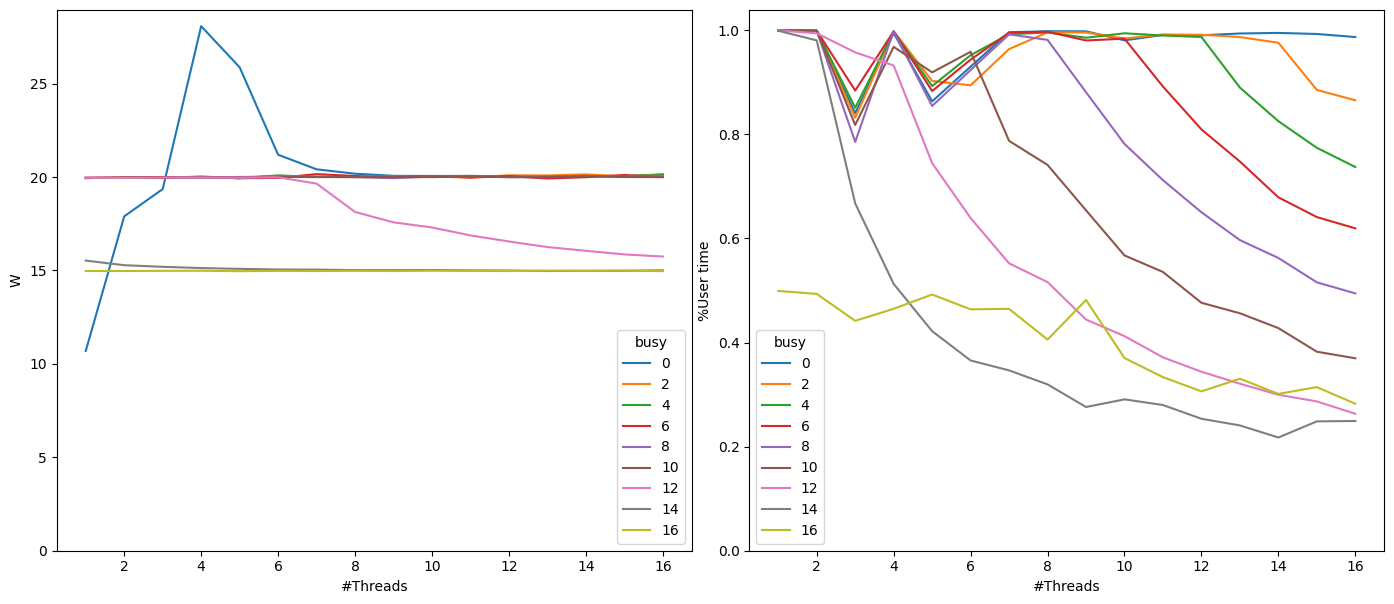

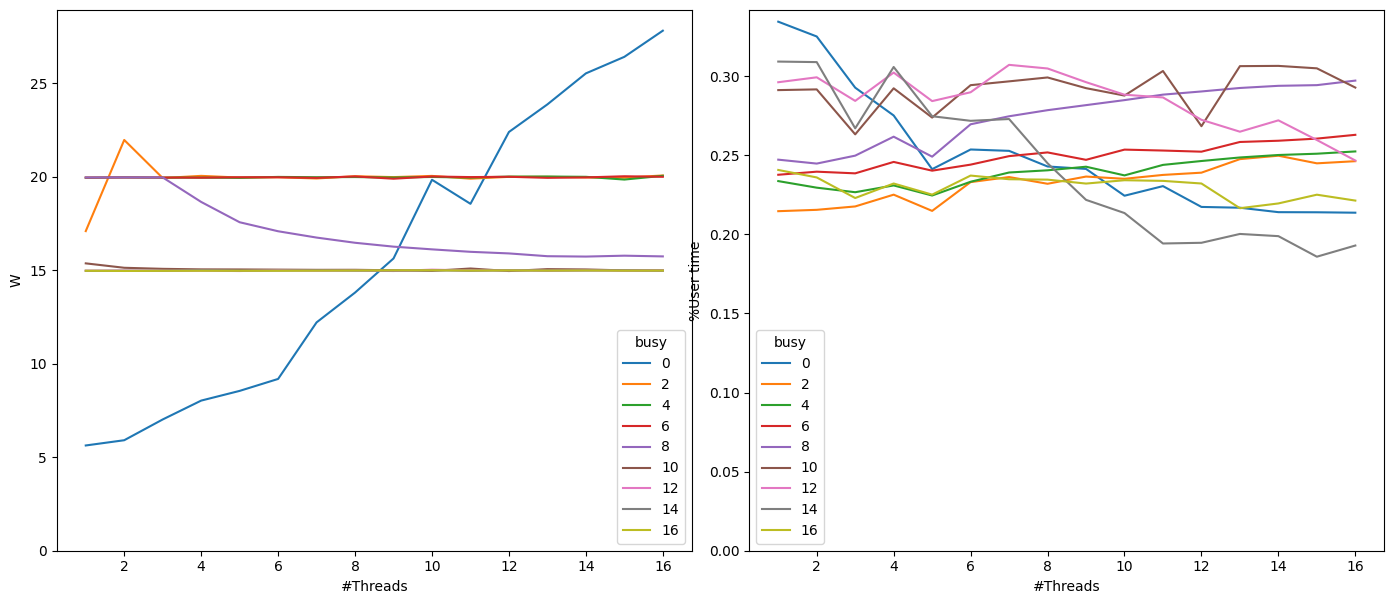

In [16]:
def plot(df):
    fig, (ax_power, ax_user) = plt.subplots(1, 2, figsize=(14,6))
    fig.tight_layout()

    # Power
    sns.lineplot(df, x='threads', y='W', hue=df['busy'].astype('category'), ax=ax_power)
    ax_power.set_xlabel('#Threads')
    ax_power.set_ylim((0, None))

    # User pct
    sns.lineplot(df, x='threads', y='user-pct', hue=df['busy'].astype('category'), ax=ax_user)
    ax_user.set_xlabel('#Threads')
    ax_user.set_ylabel('%User time')
    ax_user.set_ylim((0, None))

    plt.show()

plot(df_math)
plot(df_matmul)